In [ ]:
import re
import html
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from transformers import AutoTokenizer

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score

from IPython.display import display, HTML


/home/dviazhev/.conda/envs/qa_finetune_corr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
@dataclass(frozen=True)
class Config:
    dataset_path: str = "/home/dviazhev/complexity-aware-fine-tuning/data/out/reasoning_attn_and_entropy/phi_token_level_stats_cot.parquet" #"/home/dviazhev/complexity-aware-fine-tuning-old/data/out/attn_based_qwen/token_level_stats_cot.parquet"
    tokenizer_model_id: str = "/home/dviazhev/qa_finetune/Phi-4-mini-instruct" #"/home/dviazhev/complexity-aware-fine-tuning-old/src/models/Qwen2.5-3B-Instruct"

    answer_regex: str = r"\[\[\s*([A-Za-z]).*?\]\]"
    tail_k_viz: int = 3

    high_entropy_pct: float = 75.0
    attn_topk: int = 5
    tail_grid: Tuple[int, ...] = (1, 2, 3, 5, 10)

cfg = Config()


In [13]:
df = pd.read_parquet(cfg.dataset_path)

def _len_ok(row):
    return len(row["tokens"]) == len(row["entropies"]) == len(row["attn_importance"])

print("List lengths consistent?:", df.apply(_len_ok, axis=1).all())

answer_pattern = re.compile(cfg.answer_regex)
df["pred_letter"] = df["decoded_pred"].astype(str).str.extract(answer_pattern)[0].str.lower()
df["label_letter"] = df["decoded_label"].astype(str).str.strip().str.lower()
df["has_answer"] = df["pred_letter"].notna()

df_clean = df[
    (df["is_cot_eval"]) &
    (df["has_answer"]) &
    df["is_correct"].isin([True, False])
].copy()

print("After [[letter]] filter:", len(df_clean))

df_clean = df_clean[df_clean["input_len"].notna() & df_clean["seq_len"].notna()].copy()
df_clean["input_len"] = df_clean["input_len"].astype(int)
df_clean["seq_len"] = df_clean["seq_len"].astype(int)
df_clean = df_clean[df_clean["seq_len"] > df_clean["input_len"]].copy()

print("After length sanity:", len(df_clean))

y_incorrect = (~df_clean["is_correct"].astype(bool)).astype(int).to_numpy()


List lengths consistent?: True
After [[letter]] filter: 1752
After length sanity: 1752


In [14]:
tokenizer = AutoTokenizer.from_pretrained(cfg.tokenizer_model_id)

special_tokens = set(tokenizer.all_special_tokens)
pad_token = tokenizer.pad_token or tokenizer.eos_token

tokens = ['<|system|>','<|end|>','<|user|>','<|assistant|>']


if pad_token is not None:
    special_tokens.add(pad_token)

for token in tokens:
    special_tokens.add(token)
    
print("special_tokens:", special_tokens)


special_tokens: {'<|assistant|>', '<|end|>', '<|user|>', '<|system|>', '<|endoftext|>'}


In [15]:
def get_answer_slice(row) -> Tuple[int, int]:
    L = min(len(row["tokens"]), len(row["entropies"]), len(row["attn_importance"]))
    start = int(row["input_len"])
    end = int(row["seq_len"])
    start = max(0, min(start, L))
    end = max(start, min(end, L))
    return start, end

def is_nonspecial(tok: str) -> bool:
    return tok not in special_tokens

def extract_answer_nonspecial(row) -> Tuple[List[str], np.ndarray, np.ndarray]:
    start, end = get_answer_slice(row)

    toks = row["tokens"][start:end]
    H = np.asarray(row["entropies"][start:end], dtype=float)
    w = np.asarray(row["attn_importance"][start:end], dtype=float)

    if len(toks) == 0:
        return [], np.array([], float), np.array([], float)

    mask = np.fromiter((is_nonspecial(t) for t in toks), dtype=bool, count=len(toks))
    if not mask.any():
        return [], np.array([], float), np.array([], float)

    toks_ns = [t for t, m in zip(toks, mask) if m]
    H_ns = H[mask]
    w_ns = w[mask]
    return toks_ns, H_ns, w_ns

# Precompute once (keeps notebook snappy)
triples = df_clean.apply(extract_answer_nonspecial, axis=1)
df_clean["ans_tokens"] = triples.apply(lambda x: x[0])
df_clean["ans_H"] = triples.apply(lambda x: x[1])
df_clean["ans_w"] = triples.apply(lambda x: x[2])
df_clean["ans_len"] = df_clean["ans_tokens"].apply(len)

print("Answer tokens after removing specials:")
print(df_clean["ans_len"].describe())


Answer tokens after removing specials:
count    1752.000000
mean      401.402397
std       151.416746
min        91.000000
25%       293.000000
50%       389.000000
75%       491.000000
max      1024.000000
Name: ans_len, dtype: float64


In [16]:
def weighted_mean(x: np.ndarray, w: np.ndarray) -> float:
    if x.size == 0:
        return np.nan
    w = np.clip(w.astype(float), 0.0, None)
    s = float(w.sum())
    if s <= 1e-12:
        return float(np.mean(x))
    return float(np.dot(x, w) / s)

def frac_attn_on_high_entropy(H: np.ndarray, w: np.ndarray, thr: float) -> float:
    if H.size == 0 or not np.isfinite(thr):
        return np.nan
    w = np.clip(w.astype(float), 0.0, None)
    s = float(w.sum())
    if s <= 1e-12:
        return np.nan
    m = H > thr
    return float(w[m].sum() / s) if m.any() else 0.0

def attn_topk_agg(H: np.ndarray, w: np.ndarray, k: int, fn) -> float:
    if H.size == 0:
        return np.nan
    k = min(k, H.size)
    idx = np.argsort(-w)[:k]
    return float(fn(H[idx]))

def auc_for(scores: np.ndarray, y: np.ndarray, min_valid: int = 10) -> Optional[Tuple[float, int, int, int]]:
    mask = np.isfinite(scores)
    n_valid = int(mask.sum())
    if n_valid < min_valid:
        return None
    yy = y[mask]
    if len(np.unique(yy)) < 2:
        return None
    auc = float(roc_auc_score(yy, scores[mask]))
    n_pos = int(yy.sum())
    n_neg = int(n_valid - n_pos)
    return auc, n_valid, n_pos, n_neg

# Global high-entropy threshold on nonspecial answer tokens
all_H = np.concatenate([h for h in df_clean["ans_H"].tolist() if h is not None and len(h) > 0], axis=0)
thr_ans = float(np.nanpercentile(all_H, cfg.high_entropy_pct)) if all_H.size else np.nan
print(f"thr_ans (pct{cfg.high_entropy_pct} on nonspecial answer): {thr_ans}")

# Build metric columns
metrics = {}

H_list = df_clean["ans_H"].tolist()
w_list = df_clean["ans_w"].tolist()

metrics["unc_mean_ans"] = np.array([float(np.mean(H)) if len(H) else np.nan for H in H_list])
metrics["unc_median_ans"] = np.array([float(np.median(H)) if len(H) else np.nan for H in H_list])
metrics["unc_max_ans"] = np.array([float(np.max(H)) if len(H) else np.nan for H in H_list])

# Tail-k grid now means: last k nonspecial tokens (defined for almost all rows if len>=k)
for k in cfg.tail_grid:
    metrics[f"unc_tail{k}_mean"] = np.array([float(np.mean(H[-k:])) if len(H) >= k else np.nan for H in H_list])
    metrics[f"unc_tail{k}_max"] = np.array([float(np.max(H[-k:])) if len(H) >= k else np.nan for H in H_list])
    metrics[f"unc_tail{k}_median"] = np.array([float(np.median(H[-k:])) if len(H) >= k else np.nan for H in H_list])

metrics["unc_attn_mean_ans"] = np.array([weighted_mean(H, w) for H, w in zip(H_list, w_list)])
metrics["unc_attn_top5_mean"] = np.array([attn_topk_agg(H, w, cfg.attn_topk, np.mean) for H, w in zip(H_list, w_list)])
metrics["unc_attn_top5_max"] = np.array([attn_topk_agg(H, w, cfg.attn_topk, np.max) for H, w in zip(H_list, w_list)])
metrics["unc_frac_high_ans"] = np.array([float((H > thr_ans).mean()) if len(H) else np.nan for H in H_list])
metrics["unc_frac_attn_high"] = np.array([frac_attn_on_high_entropy(H, w, thr_ans) for H, w in zip(H_list, w_list)])

# AUC table
rows = []
for name, scores in metrics.items():
    pack = auc_for(scores.astype(float), y_incorrect, min_valid=10)
    if pack is None:
        continue
    auc, n_valid, n_pos, n_neg = pack
    rows.append((name, auc, n_valid, n_pos, n_neg))

res_df = (
    pd.DataFrame(rows, columns=["metric", "roc_auc_unc_to_incorrect", "n_valid", "n_incorrect", "n_correct"])
    .sort_values("roc_auc_unc_to_incorrect", ascending=False)
    .reset_index(drop=True)
)

print("\n=== Final AUC table (higher is better) ===")
print(res_df.to_string(index=False))


thr_ans (pct75.0 on nonspecial answer): 0.7411295771598816

=== Final AUC table (higher is better) ===
            metric  roc_auc_unc_to_incorrect  n_valid  n_incorrect  n_correct
       unc_max_ans                  0.566422     1752         1185        567
 unc_attn_mean_ans                  0.533144     1752         1185        567
unc_frac_attn_high                  0.525841     1752         1185        567
unc_attn_top5_mean                  0.524380     1752         1185        567
    unc_median_ans                  0.523411     1752         1185        567
      unc_mean_ans                  0.510502     1752         1185        567
 unc_attn_top5_max                  0.508838     1752         1185        567
    unc_tail1_mean                  0.505589     1752         1185        567
  unc_tail1_median                  0.505589     1752         1185        567
     unc_tail1_max                  0.505589     1752         1185        567
 unc_frac_high_ans                  0.5

In [24]:
import numpy as np

# Reuse your get_answer_slice() and special_tokens from earlier cells.

def extract_completion_nonspecial(row):
    start, end = get_answer_slice(row)  # input_len..seq_len
    toks = row["tokens"][start:end]
    H = np.asarray(row["entropies"][start:end], dtype=float)
    w = np.asarray(row["attn_importance"][start:end], dtype=float)

    if len(toks) == 0:
        return [], np.array([], float), np.array([], float)

    m = np.fromiter((t not in special_tokens for t in toks), dtype=bool, count=len(toks))
    if not m.any():
        return [], np.array([], float), np.array([], float)

    toks_ns = [t for t, ok in zip(toks, m) if ok]
    return toks_ns, H[m], w[m]

# If you already built ans_* earlier, just alias them.
if {"ans_tokens", "ans_H", "ans_w"}.issubset(df_clean.columns):
    df_clean["gen_tokens"] = df_clean["ans_tokens"]
    df_clean["gen_H"] = df_clean["ans_H"]
    df_clean["gen_w"] = df_clean["ans_w"]
else:
    triples = df_clean.apply(extract_completion_nonspecial, axis=1)
    df_clean["gen_tokens"] = triples.apply(lambda x: x[0])
    df_clean["gen_H"] = triples.apply(lambda x: x[1])
    df_clean["gen_w"] = triples.apply(lambda x: x[2])

df_clean["gen_len"] = df_clean["gen_tokens"].apply(len)
print(df_clean["gen_len"].describe())


count    1752.000000
mean      401.402397
std       151.416746
min        91.000000
25%       293.000000
50%       389.000000
75%       491.000000
max      1024.000000
Name: gen_len, dtype: float64


In [17]:
k = 5
tail5 = df_clean["ans_H"].apply(lambda H: float(np.mean(H[-k:])) if len(H) >= k else np.nan)
print("mean tail5 correct:", np.nanmean(tail5[df_clean["is_correct"].astype(bool)].to_numpy()))
print("mean tail5 incorrect:", np.nanmean(tail5[~df_clean["is_correct"].astype(bool)].to_numpy()))


mean tail5 correct: 0.588000331495134
mean tail5 incorrect: 0.4260433386466335


In [18]:
def w_norm(w):
    w = np.clip(np.asarray(w, float), 0.0, None)
    s = float(w.sum())
    if s <= 1e-12:
        return np.full_like(w, 1.0 / len(w)) if len(w) else w
    return w / s

def make_seq_matrix(df, N=64):
    # X: [H_tail (N), w_tail_norm (N), mask (N)]
    X = np.zeros((len(df), 3 * N), dtype=float)
    for i, (H, w) in enumerate(zip(df["ans_H"], df["ans_w"])):
        H = np.asarray(H, float)
        w = np.asarray(w, float)
        if len(H) == 0:
            continue
        w = w_norm(w)

        k = min(N, len(H))
        Ht = H[-k:]
        wt = w[-k:]
        mask = np.ones(k, dtype=float)

        # right-align (so "end of answer" is always at the same positions)
        X[i, N-k:N] = Ht
        X[i, N+(N-k):N+N] = wt
        X[i, 2*N+(N-k):2*N+N] = mask
    return X

N = 64
Xseq = make_seq_matrix(df_clean, N=N)
y = y_incorrect.astype(int)

models_seq = {
    "logreg_seq": Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc", StandardScaler()),
        ("clf", LogisticRegression(max_iter=5000, class_weight="balanced")),
    ]),
    "hgbdt_seq": Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("clf", HistGradientBoostingClassifier(max_depth=3, learning_rate=0.05, max_iter=500, random_state=42)),
    ]),
}

def cv_auc(model, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof = np.full(len(y), np.nan, float)
    for tr, te in skf.split(X, y):
        model.fit(X[tr], y[tr])
        oof[te] = model.predict_proba(X[te])[:, 1]
    return float(roc_auc_score(y, oof))

def holdout_auc(model, X, y):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    model.fit(Xtr, ytr)
    p = model.predict_proba(Xte)[:, 1]
    return float(roc_auc_score(yte, p))

for name, m in models_seq.items():
    print(name, "| CV AUC:", cv_auc(m, Xseq, y), "| Holdout AUC:", holdout_auc(m, Xseq, y))


logreg_seq | CV AUC: 0.7593537680738807 | Holdout AUC: 0.7286847323198944
hgbdt_seq | CV AUC: 0.9642444131895609 | Holdout AUC: 0.9452412425644415


In [19]:
_entropy_cmap = cm.get_cmap("Reds")
_attn_cmap = cm.get_cmap("Blues")

def _clamp01(x: float) -> float:
    return float(max(0.0, min(1.0, x)))

def _rgb_to_hex(rgba) -> str:
    r, g, b, _ = rgba
    return "#{:02x}{:02x}{:02x}".format(int(r*255), int(g*255), int(b*255))

def tok_to_text(tok: str) -> str:
    # token -> string piece; works well for HF tokenizers
    return tokenizer.convert_tokens_to_string([tok])

# Global ranges for stable coloring across examples (robust percentiles)
all_w = np.concatenate([np.clip(w, 0, None) for w in df_clean["ans_w"].tolist() if w is not None and len(w) > 0], axis=0)
H_lo, H_hi = np.nanpercentile(all_H, [1, 99]) if all_H.size else (0.0, 1.0)
w_lo, w_hi = np.nanpercentile(all_w, [1, 99]) if all_w.size else (0.0, 1.0)

def render_answer_row(row: pd.Series, tail_k: int = 3, plot: bool = True):
    toks = row["ans_tokens"]
    H = row["ans_H"]
    w = row["ans_w"]

    if len(toks) == 0:
        display(HTML("<b>Empty answer after removing special tokens</b>"))
        return

    k = min(tail_k, len(toks))
    tail_idx = set(range(len(toks) - k, len(toks)))
    tail_mean = float(np.mean(H[-k:])) if k > 0 else np.nan

    header = f"""
    <div style="font-family:system-ui, -apple-system, Segoe UI, Roboto; margin: 8px 0 10px 0;">
      <div style="font-size:14px; line-height:1.35;">
        <b>is_correct:</b> {bool(row["is_correct"])} &nbsp; | &nbsp;
        <b>tail{tail_k} mean entropy</b> (nonspecial): <b>{tail_mean:.4f}</b> &nbsp; | &nbsp;
        <b>ans_len</b>: {len(toks)}
      </div>
      <div style="margin-top:6px; font-size:12px; opacity:0.8;">
        Entropy = background (red). Attention = bottom bar (blue). Tail window = green outline.
      </div>
    </div>
    """

    spans = []
    for i, (tok, hi, wi) in enumerate(zip(toks, H, w)):
        hn = _clamp01((float(hi) - H_lo) / (H_hi - H_lo + 1e-12))
        bg = _rgb_to_hex(_entropy_cmap(hn))

        wi_pos = float(np.clip(wi, 0.0, None))
        wn = _clamp01((wi_pos - w_lo) / (w_hi - w_lo + 1e-12))
        bar = _rgb_to_hex(_attn_cmap(wn))
        bar_h = 2 + int(8 * wn)

        piece = tok_to_text(tok)
        safe = html.escape(piece).replace(" ", "&nbsp;").replace("\n", "<br/>")

        outline = "2px solid #2ecc71" if i in tail_idx else "1px solid rgba(0,0,0,0.08)"
        tooltip = html.escape(f"idx={i} | H={float(hi):.4f} | attn={float(wi):.4f}")

        spans.append(
            f"""
            <span title="{tooltip}"
              style="
                display:inline-block;
                background:{bg};
                border:{outline};
                border-radius:10px;
                margin:2px 1px;
                padding:3px 7px 2px 7px;
                position:relative;
                font-family: ui-monospace, SFMono-Regular, Menlo, Monaco, Consolas;
                font-size:12px;
                line-height:1.25;
              ">
              {safe}
              <span style="
                display:block;
                height:{bar_h}px;
                margin-top:2px;
                border-radius:10px;
                background:{bar};
                opacity:0.85;
              "></span>
            </span>
            """
        )

    block = f"""
    {header}
    <div style="
      border:1px solid rgba(0,0,0,0.08);
      border-radius:14px;
      padding:10px;
      background:rgba(0,0,0,0.02);
      overflow-x:auto;
    ">
      <div style="white-space:normal;">{''.join(spans)}</div>
    </div>
    """
    display(HTML(block))

    if plot:
        x = np.arange(len(H), dtype=int)

        plt.figure(figsize=(12, 3))
        plt.plot(x, H, marker="o", linewidth=1)
        if k > 0:
            plt.axvspan(len(H) - k - 0.5, len(H) - 0.5, alpha=0.15)
        plt.title("Entropy profile (nonspecial answer tokens)")
        plt.xlabel("token index")
        plt.ylabel("entropy")
        plt.grid(True, alpha=0.2)
        plt.show()

        plt.figure(figsize=(12, 2.2))
        plt.plot(x, np.clip(w, 0, None), marker="o", linewidth=1)
        if k > 0:
            plt.axvspan(len(H) - k - 0.5, len(H) - 0.5, alpha=0.15)
        plt.title("Attention profile (nonspecial answer tokens, clipped >=0)")
        plt.xlabel("token index")
        plt.ylabel("attn_importance")
        plt.grid(True, alpha=0.2)
        plt.show()


/tmp/job-3495981/ipykernel_112188/4004805043.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  _entropy_cmap = cm.get_cmap("Reds")
/tmp/job-3495981/ipykernel_112188/4004805043.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  _attn_cmap = cm.get_cmap("Blues")


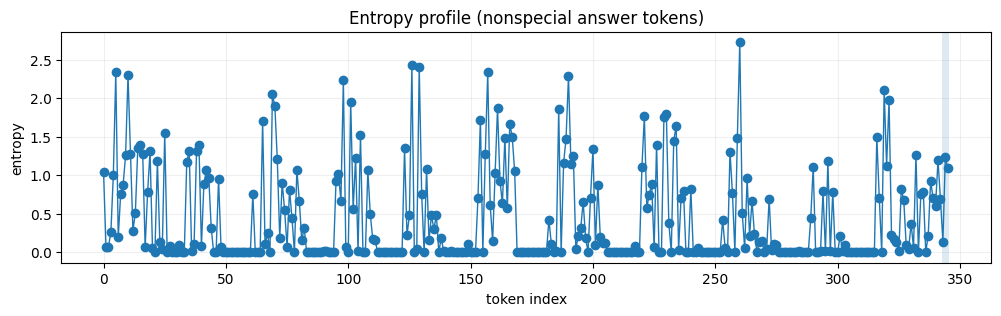

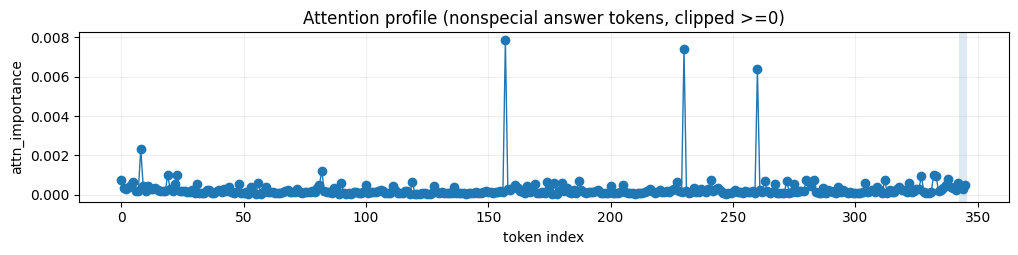

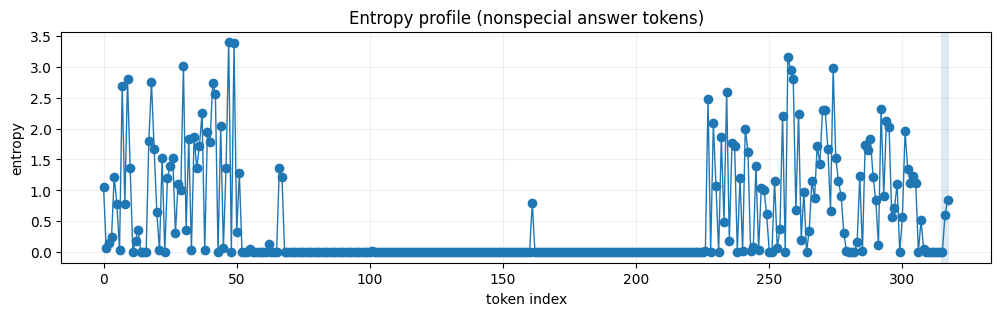

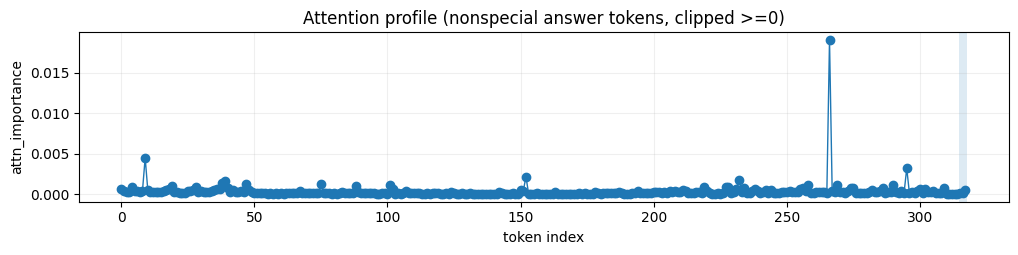

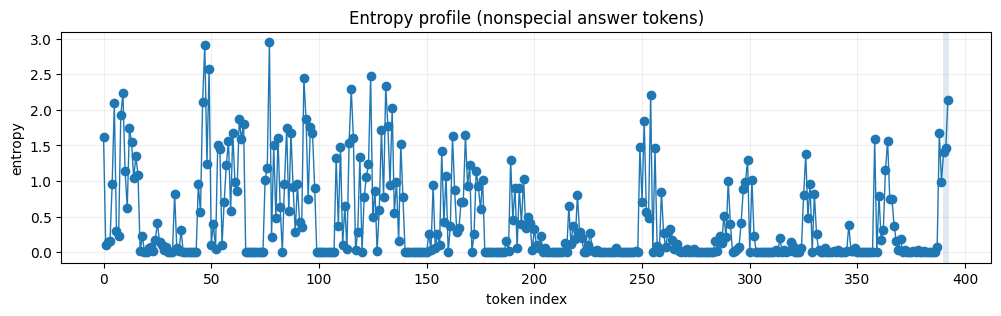

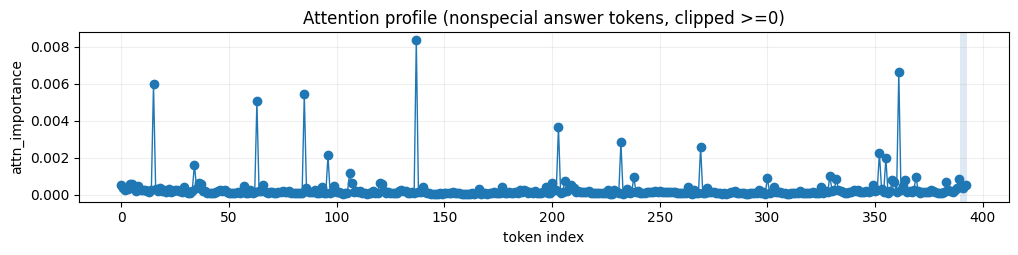

In [20]:
for _, row in df_clean.sample(3, random_state=42).iterrows():
    render_answer_row(row, tail_k=cfg.tail_k_viz, plot=True)
